This notebook aims to explore the library [`cython`](https://cython.readthedocs.io/en/latest/index.html) and its capabilities while also benchmarking the performance difference

> Author: Asif Sayyed
> Requirements: setuptools, cython

### Pi Calculation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from src.test_helper import run_benchmark, format_number, format_time

%load_ext Cython
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 250

In [2]:
def calculate_pi_python(n_terms: int) -> float:
    numerator = 4.0
    denominator = 1.0
    sign = 1.0
    pi = 0.0

    for _ in range(n_terms):
        pi += sign * (numerator / denominator)
        denominator += 2.0
        sign *= -1.0
    return pi

In [3]:
%%cython

def calculate_pi_cython(int n_terms):
    """
    Optimized Cython version of the Pi calculation function.
    """
    cdef double numerator = 4.0
    cdef double denominator = 1.0
    cdef double sign = 1.0
    cdef double pi = 0.0
    # declare the loop variable
    cdef int i

    # the nogil context manager can give more speed in specific cases
    # but for simple loops, static typing is the main benefit
    for i in range(n_terms):
        pi += sign * (numerator / denominator)
        denominator += 2.0
        sign *= -1.0
    return pi

In [19]:
functions_to_compare = {
    "Python": calculate_pi_python,
    "Cython": calculate_pi_cython,
}

# increasing the input size at log scale to see performance over different scales
input_sizes = [1_000, 10_000, 100_000, 1_000_000, 5_000_000, 10_000_000]

In [20]:
benchmark_results = run_benchmark(functions_to_compare, input_sizes, num_runs=5)

Running benchmarks...
  Testing Python...
  Testing Cython...
Finished.


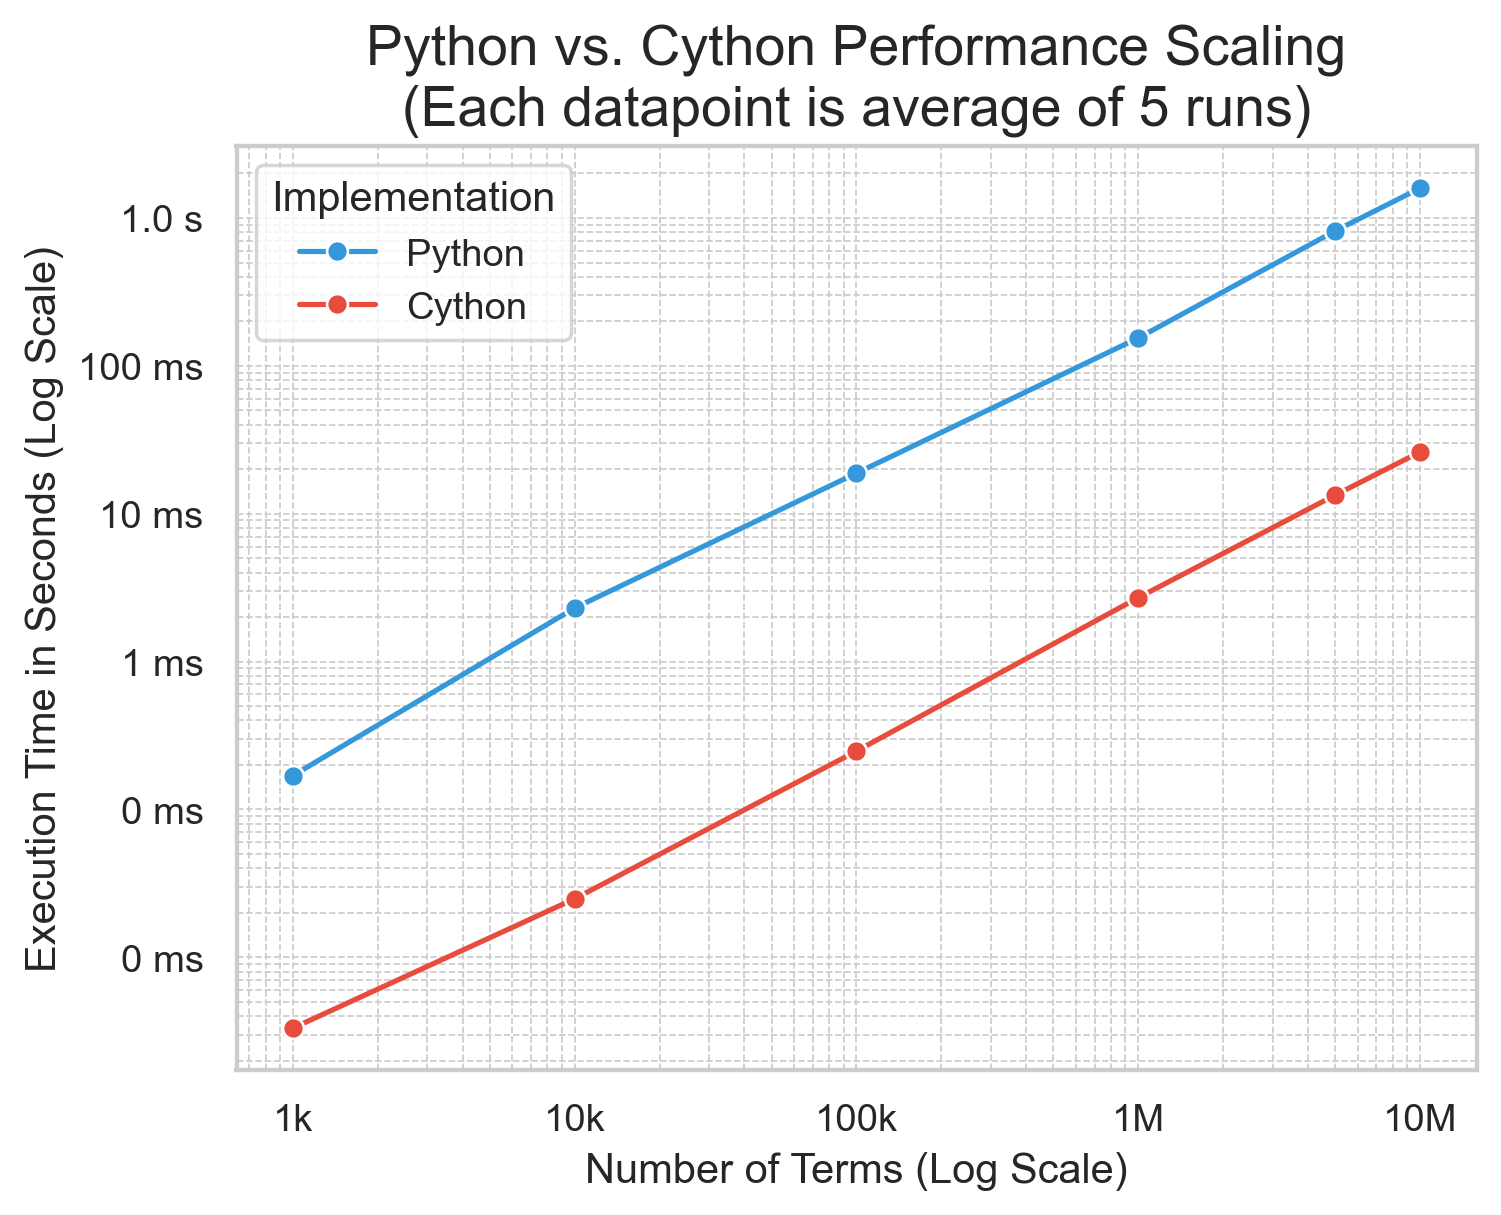

In [23]:
plot = sns.lineplot(
    data=benchmark_results,
    x='terms',
    y='time (s)',
    hue='version',
    marker='o',
    palette=['#3498db', '#e74c3c'],
)
plt.yscale('log')
plt.xscale('log')
plt.title('Python vs. Cython Performance Scaling\n(Each datapoint is average of 5 runs)', fontsize=16)
plt.xlabel('Number of Terms (Log Scale)', fontsize=12)
plt.ylabel('Execution Time in Seconds (Log Scale)', fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_number))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_time))

plt.legend(title='Implementation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()